# Part 5: Boosted Decision Trees

The `conifer` package was created out of `hls4ml`, providing a similar set of features but specifically targeting inference of Boosted Decision Trees. In this notebook we will train a `GradientBoostingClassifier` with scikit-learn, using the same jet tagging dataset as in the other tutorial notebooks. Then we will convert the model using `conifer`, and run bit-accurate prediction and synthesis as we did with `hls4ml` before.

`conifer` is available from GitHub [here](https://github.com/thesps/conifer), and we have a publication describing the inference implementation and performance in detail [here](https://iopscience.iop.org/article/10.1088/1748-0221/15/05/P05026/pdf).

<img src="https://github.com/thesps/conifer/blob/master/conifer_v1.png?raw=true" width="250" alt="conifer">

In [82]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
import joblib
import conifer
import plotting
import matplotlib.pyplot as plt
import os
os.environ['XILINX_VIVADO']='/home/rrk307/Xilinx/Vivado/2018.3'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
np.random.seed(0)

## Load the dataset
Note you need to have gone through `part1_getting_started` to download the data.

In [83]:
os.chdir('/home/rrk307/hls4ml-tutorial')
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy', allow_pickle=True)
classes = np.load('classes.npy', allow_pickle=True)

We need to transform the test labels from the one-hot encoded values to labels

In [84]:
le = LabelEncoder().fit(classes)
ohe = OneHotEncoder().fit(le.transform(classes).reshape(-1, 1))
y_train_val = ohe.inverse_transform(y_train_val.astype(int))
y_test = ohe.inverse_transform(y_test)

## Train a `GradientBoostingClassifier`
We will use 20 estimators with a maximum depth of 3. The number of decision trees will be `n_estimators * n_classes`, so 100 for this dataset. If you are returning to this notebook having already trained the BDT once, set `train = False` to load the model rather than retrain.

In [85]:
train = False
if train:
    clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=2, random_state=0, verbose=1).fit(
        X_train_val, y_train_val.ravel()
    )
    if not os.path.exists('model_6'):
        os.makedirs('model_6')
    joblib.dump(clf, 'model_6/bdt.joblib')
else:
    clf = joblib.load('model_6/bdt.joblib')

## Create a conifer configuration

Similarly to `hls4ml`, we can use a utility method to get a template for the configuration dictionary that we can modify.

In [23]:
cfg = conifer.backends.xilinxhls.auto_config()
cfg['OutputDir'] = 'model_6/conifer_prj'
cfg['XilinxPart'] = 'xc7a200tfbg676-2'   #Artix-7 FPGA
plotting.print_dict(cfg)

Backend:             xilinxhls
ProjectName:         my_prj
OutputDir:           model_6/conifer_prj
XilinxPart:          xc7a200tfbg676-2
ClockPeriod:         5
Unroll:              True
Precision:           ap_fixed<18,8>


## Convert the model
The syntax for model conversion with `conifer` is a little different to `hls4ml`. We construct a `conifer.model` object, providing the trained BDT, the converter corresponding to the library we used, the conifer 'backend' that we wish to target, and the configuration.

`conifer` has converters for:
- `sklearn`
- `xgboost`
- `tmva`

And backends:
- `vivadohls`
- `vitishls`
- `xilinxhls` (use whichever `vivado` or `vitis` is on the path
- `vhdl`

Here we will use the `sklearn` converter, since that's how we trained our model, and the `vivadohls` backend. For larger BDTs with many more trees or depth, it may be preferable to generate VHDL directly using the `vhdl` backend to get best performance. See [our paper](https://iopscience.iop.org/article/10.1088/1748-0221/15/05/P05026/pdf) for the performance comparison between those backends.

In [6]:
# Create and compile the model
model = conifer.converters.convert_from_sklearn(clf, cfg)
model.compile()

Accuracy sklearn: 0.7366204819277108
Accuracy conifer: 0.736644578313253


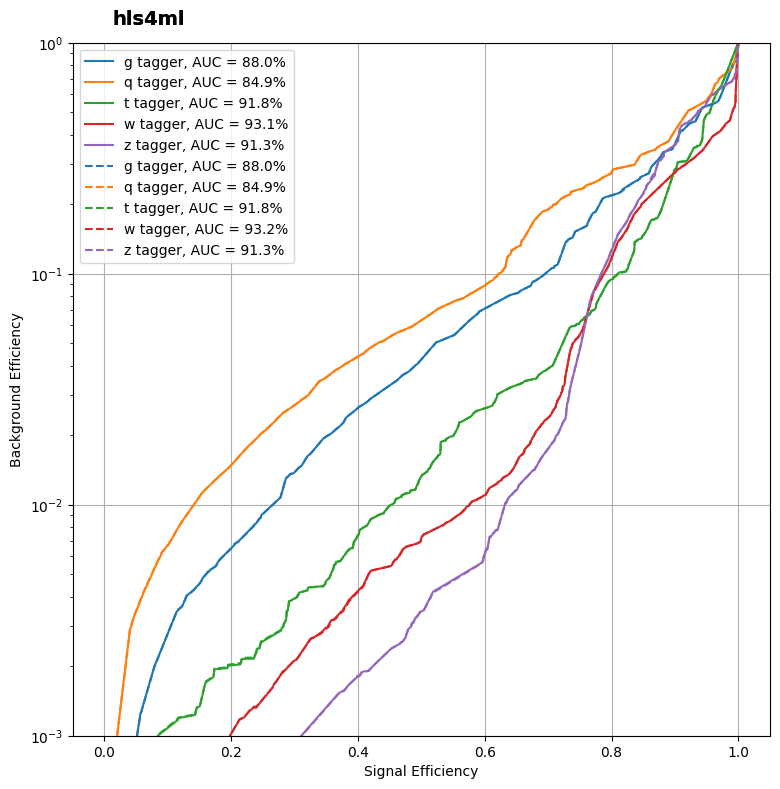

In [7]:
y_skl = clf.decision_function(X_test)
y_cnf = model.decision_function(X_test)
yt = ohe.transform(y_test).toarray().astype(int)
print("Accuracy sklearn: {}".format(accuracy_score(np.argmax(yt, axis=1), np.argmax(y_skl, axis=1))))
print("Accuracy conifer: {}".format(accuracy_score(np.argmax(yt, axis=1), np.argmax(y_cnf, axis=1))))
fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(yt, y_skl, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(yt, y_cnf, classes, linestyle='--')

## Synthesize
Now run the Vivado HLS C Synthesis step to produce an IP that we can use, and inspect the estimate resources and latency.
You can see some live output while the synthesis is running by opening a terminal from the Jupyter home page and executing:
`tail -f model_5/conifer_prj/vivado_hls.log`

In [38]:
model.build()

True

## Read report
We can use an hls4ml utility to read the Vivado report

In [39]:
f=open(cfg['OutputDir'] + '/my_prj_prj/solution1/syn/report/my_prj_csynth.rpt','r')
print(f.read())



== Vivado HLS Report for 'my_prj'
* Date:           Tue Jul 25 12:16:04 2023

* Version:        2018.3 (Build 2405991 on Thu Dec 06 23:56:15 MST 2018)
* Project:        my_prj_prj
* Solution:       solution1
* Product family: artix7
* Target device:  xc7a200tfbg676-2


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     3.845|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |    5|    5|    1|    1| function |
    +-----+-----+-----+-----+----------+

    + Detail: 
        * Instance: 
        +---------------------------------+----------------------+-----+-----+-----+-----+----------+
       

### Random Forest

#### Testing with rounding operation to thresholds

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# Train a BDT
clf = RandomForestClassifier(
    n_estimators=3, max_depth=5, random_state=0).fit( X_train_val, y_train_val.ravel())

pred=clf.predict(X_test)
print('Before rounding to nearest integer')
print ("Classification Report")
print(classification_report(y_test, pred))

for i,dt in enumerate(clf.estimators_):
    print(dt.tree_.threshold)
    
for i,dt in enumerate(clf.estimators_):
    for j,thd in enumerate(dt.tree_.threshold):
        clf.estimators_[i].tree_.threshold[j] = round(j)
        
print('After rounding to nearest integer')
for i,dt in enumerate(clf.estimators_):
    print(dt.tree_.threshold)
    
pred=clf.predict(X_test)
print ("Classification Report")
print(classification_report(y_test, pred))

Before rounding to nearest integer
Classification Report
              precision    recall  f1-score   support

           0       0.63      0.68      0.65     33414
           1       0.59      0.66      0.62     32216
           2       0.79      0.78      0.78     33475
           3       0.75      0.75      0.75     33595
           4       0.87      0.69      0.77     33300

    accuracy                           0.71    166000
   macro avg       0.72      0.71      0.72    166000
weighted avg       0.73      0.71      0.72    166000

[ 0.93971717  0.17952049 -0.16502757 -0.80775088 -0.3913448  -2.
 -2.         -0.76053599 -2.         -2.         -0.24935847 -0.42563373
 -2.         -2.         -0.37322378 -2.         -2.          0.07650161
 -0.11636368 -1.22302312 -2.         -2.         -0.16211526 -2.
 -2.         -0.49727909  0.77519202 -2.         -2.          1.13446164
 -2.         -2.          1.11445773  0.35845509  0.85769761  0.04442548
 -2.         -2.          0.0324

/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [113]:
for i,dt in enumerate(clf.estimators_):
    print('Minimum and maximum threshold value is ',min(dt.tree_.threshold), max(dt.tree_.threshold))
    
print('Thresholds of decision trees')
for i,dt in enumerate(clf.estimators_):
    print(dt.tree_.threshold)

Minimum and maximum threshold value is  0.0 62.0
Minimum and maximum threshold value is  0.0 62.0
Minimum and maximum threshold value is  0.0 62.0
Thresholds of decision trees
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62.]


#### Rounding operation has reduced the accuracy to 30%. To encrypt the model, the thresholds has to be converted to integer. 

#### HLS for plain RF model (with rounding).

In [15]:
from sklearn.ensemble import RandomForestClassifier
# Train a BDT
clf = RandomForestClassifier(
    n_estimators=3, max_depth=5, random_state=0).fit( X_train_val, y_train_val.ravel())

# Create a conifer config
cfg = conifer.backends.xilinxhls.auto_config()
# Set the output directory to something unique
cfg['OutputDir'] = 'model_7/conifer_prj'
cfg['XilinxPart'] = 'xc7a200tfbg676-2'   #Artix-7 FPGA
cfg['Precision'] = 'ap_fixed<6,6>' #Since the max threshold value is 62, a six-bit size is sufficient.
plotting.print_dict(cfg)
# Create and compile the model
model = conifer.converters.convert_from_sklearn(clf, cfg)
model.compile()

# Run HLS C Simulation and get the output
y_skl = clf.predict_proba(X_test)
y_cnf = model.decision_function(X_test)
yt = ohe.transform(y_test).toarray().astype(int)
print("Accuracy sklearn: {}".format(accuracy_score(np.argmax(yt, axis=1), np.argmax(y_skl, axis=1))))
print("Accuracy conifer: {}".format(accuracy_score(np.argmax(yt, axis=1), np.argmax(y_cnf, axis=1))))

# Synthesize the model
model.build()

f=open(cfg['OutputDir'] + '/my_prj_prj/solution1/syn/report/my_prj_csynth.rpt','r')
print(f.read())

Backend:             xilinxhls
ProjectName:         my_prj
OutputDir:           model_7/conifer_prj
XilinxPart:          xc7a200tfbg676-2
ClockPeriod:         5
Unroll:              True
Precision:           ap_fixed<6,6>
Accuracy sklearn: 0.7142168674698796
Accuracy conifer: 0.20060240963855422


== Vivado HLS Report for 'my_prj'
* Date:           Tue Sep 19 13:02:30 2023

* Version:        2018.3 (Build 2405991 on Thu Dec 06 23:56:15 MST 2018)
* Project:        my_prj_prj
* Solution:       solution1
* Product family: artix7
* Target device:  xc7a200tfbg676-2


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.372|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | m

#### Encrypt the trees and dataset using the ciphertexts generated in "McEliece Code-based Cryptography.ipynb" notebook file. 

In [16]:
ciphertexts = {-2: 1011, -1: 1019, 0: 1028, 1: 1034, 2: 1041, 3: 1055, 4: 1063, 5: 1065, 6: 1074, 7: 1084, 8: 1091, 9: 1101, 10: 1110, 11: 1112, 12: 1120, 13: 1134, 14: 1141, 15: 1147, 16: 2564, 17: 2570, 18: 2577, 19: 2591, 20: 2599, 21: 2601, 22: 2610, 23: 2620, 24: 2627, 25: 2637, 26: 2646, 27: 2648, 28: 2656, 29: 2670, 30: 2677, 31: 2683, 32: 4356, 33: 4362, 34: 4369, 35: 4383, 36: 4391, 37: 4393, 38: 4402, 39: 4412, 40: 4419, 41: 4429, 42: 4438, 43: 4440, 44: 4448, 45: 4462, 46: 4469, 47: 4475, 48: 7940, 49: 7946, 50: 7953, 51: 7967, 52: 7975, 53: 7977, 54: 7986, 55: 7996, 56: 8003, 57: 8013, 58: 8022, 59: 8024, 60: 8032, 61: 8046, 62: 8053, 63: 8059, 64: 9988, 65: 9994, 66: 10001, 67: 10015, 68: 10023, 69: 10025, 70: 10034, 71: 10044, 72: 10051, 73: 10061, 74: 10070, 75: 10072, 76: 10080, 77: 10094, 78: 10101, 79: 10107, 80: 10500, 81: 10506, 82: 10513, 83: 10527, 84: 10535, 85: 10537, 86: 10546, 87: 10556, 88: 10563, 89: 10573, 90: 10582, 91: 10584, 92: 10592, 93: 10606, 94: 10613, 95: 10619, 96: 12804, 97: 12810, 98: 12817, 99: 12831, 100: 12839, 101: 12841, 102: 12850, 103: 12860, 104: 12867, 105: 12877, 106: 12886, 107: 12888, 108: 12896, 109: 12910, 110: 12917, 111: 12923, 112: 15364, 113: 15370, 114: 15377, 115: 15391, 116: 15399, 117: 15401, 118: 15410, 119: 15420, 120: 15427, 121: 15437, 122: 15446, 123: 15448, 124: 15456, 125: 15470, 126: 15477, 127: 15483, 128: 17156, 129: 17162, 130: 17169, 131: 17183, 132: 17191, 133: 17193, 134: 17202, 135: 17212, 136: 17219, 137: 17229, 138: 17238, 139: 17240, 140: 17248, 141: 17262, 142: 17269, 143: 17275, 144: 19716, 145: 19722, 146: 19729, 147: 19743, 148: 19751, 149: 19753, 150: 19762, 151: 19772, 152: 19779, 153: 19789, 154: 19798, 155: 19800, 156: 19808, 157: 19822, 158: 19829, 159: 19835, 160: 22020, 161: 22026, 162: 22033, 163: 22047, 164: 22055, 165: 22057, 166: 22066, 167: 22076, 168: 22083, 169: 22093, 170: 22102, 171: 22104, 172: 22112, 173: 22126, 174: 22133, 175: 22139, 176: 22532, 177: 22538, 178: 22545, 179: 22559, 180: 22567, 181: 22569, 182: 22578, 183: 22588, 184: 22595, 185: 22605, 186: 22614, 187: 22616, 188: 22624, 189: 22638, 190: 22645, 191: 22651, 192: 24580, 193: 24586, 194: 24593, 195: 24607, 196: 24615, 197: 24617, 198: 24626, 199: 24636, 200: 24643, 201: 24653, 202: 24662, 203: 24664, 204: 24672, 205: 24686, 206: 24693, 207: 24699, 208: 28164, 209: 28170, 210: 28177, 211: 28191, 212: 28199, 213: 28201, 214: 28210, 215: 28220, 216: 28227, 217: 28237, 218: 28246, 219: 28248, 220: 28256, 221: 28270, 222: 28277, 223: 28283, 224: 29956, 225: 29962, 226: 29969, 227: 29983, 228: 29991, 229: 29993, 230: 30002, 231: 30012, 232: 30019, 233: 30029, 234: 30038, 235: 30040, 236: 30048, 237: 30062, 238: 30069, 239: 30075, 240: 31492, 241: 31498, 242: 31505, 243: 31519, 244: 31527, 245: 31529, 246: 31538, 247: 31548, 248: 31555, 249: 31565, 250: 31574, 251: 31576, 252: 31584, 253: 31598, 254: 31605, 255:31643}
for i,dt in enumerate(clf.estimators_):
    for j,thd in enumerate(dt.tree_.threshold):
        clf.estimators_[i].tree_.threshold[j] = ciphertexts[int(round(thd))]
        
for i in clf.classes_:
    clf.classes_[i] = ciphertexts[i]
    
cfg = conifer.backends.xilinxhls.auto_config()
# Set the output directory to something unique
cfg['OutputDir'] = 'model_McElieceJettag_RF/conifer_prj'
cfg['XilinxPart'] = 'xc7a200tfbg676-2'   #Artix-7 FPGA
cfg['Precision'] = 'ap_fixed<16,16>'
print(cfg)
# Create and compile the model
model = conifer.converters.convert_from_sklearn(clf, cfg)
model.compile()

{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RF/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


#### Synthesize the model.

In [17]:
model.build()

f=open(cfg['OutputDir'] + '/build.log','r')
print(f.read())


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP Build 2404404 on Fri Dec  7 01:43:56 MST 2018
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.

source /home/rrk307/Xilinx/Vivado/2018.3/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/home/rrk307/Xilinx/Vivado/2018.3/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'rrk307' on host 'ADUAED10599LPLX' (Linux_x86_64 version 5.4.0-150-generic) on Tue Sep 19 13:03:14 +04 2023
INFO: [HLS 200-10] On os Ubuntu 18.04.6 LTS
INFO: [HLS 200-10] In directory '/home/rrk307/hls4ml-tutorial/model_McElieceJettag_RF/conifer_prj'
INFO: [HLS 200-10] Creating and opening project '/home/rrk307/hls4ml-tutorial/model_McElieceJettag_RF/conifer_prj/my_prj_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/BDT.h' to the project
INFO: [HLS 200-10] Adding design file 'firmware/BDT.cpp' to the project
INFO: [HLS 200-10]

#### Read the synthesis report.

In [18]:
f=open(cfg['OutputDir'] + '/my_prj_prj/solution1/syn/report/my_prj_csynth.rpt','r')
print(f.read())



== Vivado HLS Report for 'my_prj'
* Date:           Tue Sep 19 13:03:41 2023

* Version:        2018.3 (Build 2405991 on Thu Dec 06 23:56:15 MST 2018)
* Project:        my_prj_prj
* Solution:       solution1
* Product family: artix7
* Target device:  xc7a200tfbg676-2


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.372|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |    7|    7|    1|    1| function |
    +-----+-----+-----+-----+----------+

    + Detail: 
        * Instance: 
        +--------------------------------+---------------------+-----+-----+-----+-----+----------+
        |

#### Profiling Accuracy for various RF architecture

##### Scaling trees

In [40]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
train_acc = {}
val_acc = {}
nodes_count = {}
leaves_count = {}
rf_clf = {}
for n_tree in range(3,20,2):
    rf_clf[n_tree] = RandomForestClassifier(n_estimators=n_tree, max_depth=5)

    y_train_pred = cross_val_predict(rf_clf[n_tree], X_train_val, y_train_val.ravel(), cv=2)
    rf_clf[n_tree].fit( X_train_val, y_train_val.ravel())

    from sklearn.model_selection import cross_val_score
    train_acc[n_tree] = np.mean(cross_val_score(rf_clf[n_tree], X_train_val, y_train_val.ravel(), cv=2, scoring="accuracy"))
    val_acc[n_tree] = np.mean(cross_val_score(rf_clf[n_tree], X_test, y_test, cv=2, scoring="accuracy"))
    nodes_count[n_tree] = [tree_i.tree_.node_count for tree_i in rf_clf[n_tree].estimators_]
    leaves_count[n_tree] = [tree_i.tree_.n_leaves for tree_i in rf_clf[n_tree].estimators_]

/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarni

Training accuracy:  {3: 0.7153313253012048, 5: 0.714527108433735, 7: 0.719085843373494, 9: 0.7168960843373494, 11: 0.7198885542168675, 13: 0.7225060240963856, 15: 0.7254006024096386, 17: 0.7211144578313253, 19: 0.7271987951807228}
Testing accuracy:  {3: 0.7143855421686747, 5: 0.712355421686747, 7: 0.7096506024096385, 9: 0.7115301204819278, 11: 0.7177409638554217, 13: 0.7180120481927711, 15: 0.7180602409638555, 17: 0.7180843373493976, 19: 0.7244397590361447}
Nodes count:  {3: [63, 63, 63], 5: [63, 63, 63, 63, 63], 7: [63, 63, 63, 63, 63, 63, 63], 9: [63, 63, 63, 63, 63, 63, 63, 63, 63], 11: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63], 13: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63], 15: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63], 17: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63], 19: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63]}
Leaves count:  {3: [32, 32, 32], 5: [32, 32, 32, 32, 32], 7: [32, 32, 32, 32,

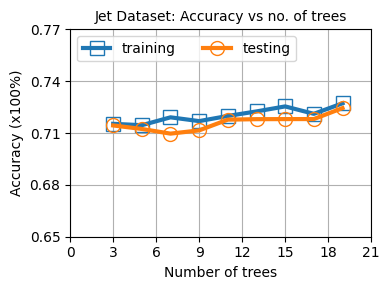

In [87]:
print('Training accuracy: ',train_acc)
print('======================')
print('Testing accuracy: ',val_acc)
print('======================')
print('Nodes count: ',nodes_count)
print('======================')
print('Leaves count: ',leaves_count)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(4, 3))
plt.plot(train_acc.keys(), train_acc.values(), marker = 's', markersize=10, fillstyle = 'none', linewidth=3, label = 'training')
plt.plot(val_acc.keys(), val_acc.values(), marker = 'o', markersize=10, fillstyle = 'none', linewidth=3, label = 'testing')
plt.xlabel('Number of trees', size=10)
plt.ylabel('Accuracy (x100%)', size=10)
plt.title('Jet Dataset: Accuracy vs no. of trees', size=10)
plt.grid()
plt.yticks([0.65, 0.68, 0.71, 0.74, 0.77], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=2, loc='upper left')
plt.tight_layout()
plt.savefig('accuracy_rf_Jet.pdf')
plt.show()

In [35]:
import os
os.getcwd()

'/home/rrk307/hls4ml-tutorial'

#### FPGA resource utilization for various RF architecture.

In [41]:
FPGA_build_logs = {}
for n_tree in rf_clf.keys():
    for i,dt in enumerate(rf_clf[n_tree].estimators_):
        for j,thd in enumerate(dt.tree_.threshold):
            rf_clf[n_tree].estimators_[i].tree_.threshold[j] = ciphertexts[int(round(thd))]
        
    for i in rf_clf[n_tree].classes_:
        rf_clf[n_tree].classes_[i] = ciphertexts[i]
    print(f'Building for RF with {n_tree} trees.')
    cfg = conifer.backends.xilinxhls.auto_config()
    # Set the output directory to something unique
    cfg['OutputDir'] = f'model_McElieceJettag_RFtree_{n_tree}/conifer_prj'
    cfg['XilinxPart'] = 'xc7a200tfbg676-2'   #Artix-7 FPGA
    cfg['Precision'] = 'ap_fixed<16,16>'
    print(cfg)
    # Create and compile the model
    model = conifer.converters.convert_from_sklearn(rf_clf[n_tree], cfg)
    model.compile()
    model.build()
    f=open(cfg['OutputDir'] + '/my_prj_prj/solution1/syn/report/my_prj_csynth.rpt','r')
    FPGA_build_logs[n_tree] = f.read()    
    f.close()

Building for RF with 3 trees.
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_3/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with 5 trees.
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with 7 trees.
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with 9 trees.
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with 11 trees.
{'Backend

In [59]:
FFs = {}
LUTs = {}
FFs_Utilization = {}
LUTs_Utilization = {}
for n_tree in FPGA_build_logs.keys():
    for line in FPGA_build_logs[n_tree].split('\n'):
        if '|Total            |' in line:
            line = line.split('0|      0|')[1].split('|')  #FF and LUTs
            FFs[n_tree] = int(line[0].strip())
            LUTs[n_tree] = int(line[1].strip())
        if '|Utilization (%)  |' in line:
            line = line.split('0|      0|')[1].split('|')
            FFs_Utilization[n_tree] = int(line[0].strip())
            LUTs_Utilization[n_tree] = int(line[1].strip())
            
print(FFs, LUTs, FFs_Utilization, LUTs_Utilization)

{3: 3801, 5: 6400, 7: 7622, 9: 10893, 11: 13907, 13: 15145, 15: 19023, 17: 21078, 19: 22348} {3: 4059, 5: 6773, 7: 8559, 9: 11840, 11: 14961, 13: 16733, 15: 20371, 17: 22742, 19: 24468} {3: 1, 5: 2, 7: 2, 9: 4, 11: 5, 13: 5, 15: 7, 17: 7, 19: 8} {3: 3, 5: 5, 7: 6, 9: 9, 11: 11, 13: 12, 15: 15, 17: 17, 19: 18}


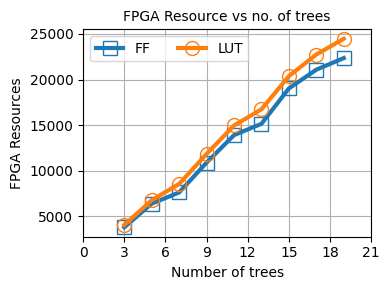

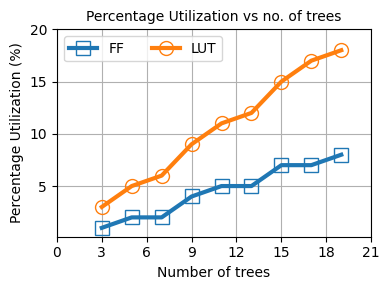

In [79]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(4, 3))
plt.plot(FPGA_build_logs.keys(), FFs.values(), marker = 's', markersize=10, fillstyle = 'none', linewidth=3, label = 'FF')
plt.plot(FPGA_build_logs.keys(), LUTs.values(), marker = 'o', markersize=10, fillstyle = 'none', linewidth=3, label = 'LUT')
plt.xlabel('Number of trees', size=10)
plt.ylabel('FPGA Resources', size=10)
plt.title('FPGA Resource vs no. of trees', size=10)
plt.grid()
plt.yticks([5000, 10000, 15000, 20000, 25000], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=2, loc='upper left')
plt.tight_layout()
plt.savefig('fpgares_rf_Jet.pdf')
plt.show()

figure(figsize=(4, 3))
plt.plot(FPGA_build_logs.keys(), FFs_Utilization.values(), marker = 's', markersize=10, fillstyle = 'none', linewidth=3, label = 'FF')
plt.plot(FPGA_build_logs.keys(), LUTs_Utilization.values(), marker = 'o', markersize=10, fillstyle = 'none', linewidth=3, label = 'LUT')
plt.xlabel('Number of trees', size=10)
plt.ylabel('Percentage Utilization (%)', size=10)
plt.title('Percentage Utilization vs no. of trees', size=10)
plt.grid()
plt.yticks([5, 10, 15, 20], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=2, loc='upper left')
plt.tight_layout()
plt.savefig('fpgarespers_rf_Jet.pdf')
plt.show()

#### Deeper trees

In [105]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
train_acc = {}
val_acc = {}
nodes_count = {}
leaves_count = {}
rf_clf = {}
for n_tree in range(3,20,2):
    for depth in range(5,12,2):
        print(f'Testing for {(n_tree,depth)}.')
        rf_clf[(n_tree,depth)] = RandomForestClassifier(n_estimators=n_tree, max_depth=depth)

        y_train_pred = cross_val_predict(rf_clf[(n_tree,depth)], X_train_val, y_train_val.ravel(), cv=2)
        rf_clf[(n_tree,depth)].fit( X_train_val, y_train_val.ravel())

        from sklearn.model_selection import cross_val_score
        train_acc[(n_tree,depth)] = np.mean(cross_val_score(rf_clf[(n_tree,depth)], X_train_val, y_train_val.ravel(), cv=2, scoring="accuracy"))
        val_acc[(n_tree,depth)] = np.mean(cross_val_score(rf_clf[(n_tree,depth)], X_test, y_test, cv=2, scoring="accuracy"))
        nodes_count[(n_tree,depth)] = [tree_i.tree_.node_count for tree_i in rf_clf[(n_tree,depth)].estimators_]
        leaves_count[(n_tree,depth)] = [tree_i.tree_.n_leaves for tree_i in rf_clf[(n_tree,depth)].estimators_]

Testing for (3, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (3, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (3, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (3, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (5, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (5, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (5, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (5, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (7, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (7, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (7, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (7, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (9, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (9, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (9, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (9, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (11, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (11, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (11, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (11, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (13, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (13, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (13, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (13, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (15, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (15, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (15, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (15, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (17, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (17, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (17, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (17, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (19, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (19, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (19, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (19, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [106]:
import pickle
with open('rf_clf_jet.pickle', 'wb') as handle:
    pickle.dump(rf_clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

##### Accuracy

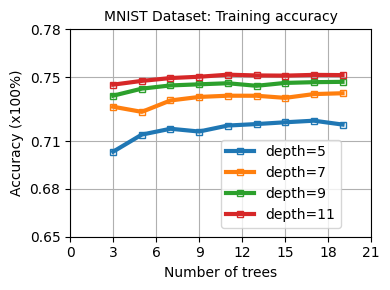

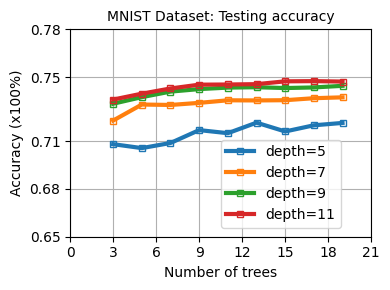

In [107]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in train_acc.keys()]):
    plt.plot(np.unique([i[0] for i in train_acc.keys()]), [train_acc[j,depth] for j in np.unique([i[0] for i in train_acc.keys()])], marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))
    #plt.plot(np.unique([i[0] for i in val_acc.keys()]), [val_acc[j,depth] for j in np.unique([i[0] for i in val_acc.keys()])], marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))
plt.xlabel('Number of trees', size=10)
plt.ylabel('Accuracy (x100%)', size=10)
plt.title('MNIST Dataset: Training accuracy', size=10)
plt.grid()
plt.yticks([0.65, 0.68, 0.71, 0.75, 0.78], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, bbox_to_anchor=(0.70, 0.01), loc='lower center')
plt.tight_layout()
plt.savefig('accuracy_rf_Jet_train.pdf')
plt.show()

figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in train_acc.keys()]):
    plt.plot(np.unique([i[0] for i in val_acc.keys()]), [val_acc[j,depth] for j in np.unique([i[0] for i in val_acc.keys()])], marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))
plt.xlabel('Number of trees', size=10)
plt.ylabel('Accuracy (x100%)', size=10)
plt.title('MNIST Dataset: Testing accuracy', size=10)
plt.grid()
plt.yticks([0.65, 0.68, 0.71, 0.75, 0.78], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, bbox_to_anchor=(0.70, 0.01), loc='lower center')
plt.tight_layout()
plt.savefig('accuracy_rf_Jet_test.pdf')
plt.show()

##### FPGA Resource Utilization

In [120]:
with open('rf_clf_jet.pickle', 'rb') as handle:
    rf_clf_jet = pickle.load(handle)

In [123]:
min_max_thd = []
for n_tree in np.unique([i[0] for i in train_acc.keys()]):
    for depth in np.unique([i[1] for i in train_acc.keys()]):
        for i,dt in enumerate(rf_clf_jet[(n_tree,depth)].estimators_):
            min_max_thd.append(min(dt.tree_.threshold))
            min_max_thd.append(max(dt.tree_.threshold))
print('Thresholds are in range',min(min_max_thd), max(min_max_thd))
ciphertexts = {-7:942, -6:964, -5:978, -4:987, -3:1001, -2: 1011, -1: 1019, 0: 1028, 1: 1034, 2: 1041, 3: 1055, 4: 1063, 5: 1065, 6: 1074, 7: 1084, 8: 1091, 9: 1101, 10: 1110, 11: 1112, 12: 1120, 13: 1134, 14: 1141, 15: 1147, 16: 2564, 17: 2570, 18: 2577, 19: 2591, 20: 2599, 21: 2601, 22: 2610, 23: 2620, 24: 2627, 25: 2637, 26: 2646, 27: 2648, 28: 2656, 29: 2670, 30: 2677, 31: 2683, 32: 4356, 33: 4362, 34: 4369, 35: 4383, 36: 4391, 37: 4393, 38: 4402, 39: 4412, 40: 4419, 41: 4429, 42: 4438, 43: 4440, 44: 4448, 45: 4462, 46: 4469, 47: 4475, 48: 7940, 49: 7946, 50: 7953, 51: 7967, 52: 7975, 53: 7977, 54: 7986, 55: 7996, 56: 8003, 57: 8013, 58: 8022, 59: 8024, 60: 8032, 61: 8046, 62: 8053, 63: 8059, 64: 9988, 65: 9994, 66: 10001, 67: 10015, 68: 10023, 69: 10025, 70: 10034, 71: 10044, 72: 10051, 73: 10061, 74: 10070, 75: 10072, 76: 10080, 77: 10094, 78: 10101, 79: 10107, 80: 10500, 81: 10506, 82: 10513, 83: 10527, 84: 10535, 85: 10537, 86: 10546, 87: 10556, 88: 10563, 89: 10573, 90: 10582, 91: 10584, 92: 10592, 93: 10606, 94: 10613, 95: 10619, 96: 12804, 97: 12810, 98: 12817, 99: 12831, 100: 12839, 101: 12841, 102: 12850, 103: 12860, 104: 12867, 105: 12877, 106: 12886, 107: 12888, 108: 12896, 109: 12910, 110: 12917, 111: 12923, 112: 15364, 113: 15370, 114: 15377, 115: 15391, 116: 15399, 117: 15401, 118: 15410, 119: 15420, 120: 15427, 121: 15437, 122: 15446, 123: 15448, 124: 15456, 125: 15470, 126: 15477, 127: 15483, 128: 17156, 129: 17162, 130: 17169, 131: 17183, 132: 17191, 133: 17193, 134: 17202, 135: 17212, 136: 17219, 137: 17229, 138: 17238, 139: 17240, 140: 17248, 141: 17262, 142: 17269, 143: 17275, 144: 19716, 145: 19722, 146: 19729, 147: 19743, 148: 19751, 149: 19753, 150: 19762, 151: 19772, 152: 19779, 153: 19789, 154: 19798, 155: 19800, 156: 19808, 157: 19822, 158: 19829, 159: 19835, 160: 22020, 161: 22026, 162: 22033, 163: 22047, 164: 22055, 165: 22057, 166: 22066, 167: 22076, 168: 22083, 169: 22093, 170: 22102, 171: 22104, 172: 22112, 173: 22126, 174: 22133, 175: 22139, 176: 22532, 177: 22538, 178: 22545, 179: 22559, 180: 22567, 181: 22569, 182: 22578, 183: 22588, 184: 22595, 185: 22605, 186: 22614, 187: 22616, 188: 22624, 189: 22638, 190: 22645, 191: 22651, 192: 24580, 193: 24586, 194: 24593, 195: 24607, 196: 24615, 197: 24617, 198: 24626, 199: 24636, 200: 24643, 201: 24653, 202: 24662, 203: 24664, 204: 24672, 205: 24686, 206: 24693, 207: 24699, 208: 28164, 209: 28170, 210: 28177, 211: 28191, 212: 28199, 213: 28201, 214: 28210, 215: 28220, 216: 28227, 217: 28237, 218: 28246, 219: 28248, 220: 28256, 221: 28270, 222: 28277, 223: 28283, 224: 29956, 225: 29962, 226: 29969, 227: 29983, 228: 29991, 229: 29993, 230: 30002, 231: 30012, 232: 30019, 233: 30029, 234: 30038, 235: 30040, 236: 30048, 237: 30062, 238: 30069, 239: 30075, 240: 31492, 241: 31498, 242: 31505, 243: 31519, 244: 31527, 245: 31529, 246: 31538, 247: 31548, 248: 31555, 249: 31565, 250: 31574, 251: 31576, 252: 31584, 253: 31598, 254: 31605, 255:31643}

Thresholds are in range -6.172813415527344 7.124598741531372


In [124]:
for n_tree in np.unique([i[0] for i in train_acc.keys()]):
    for depth in np.unique([i[1] for i in train_acc.keys()]):
        for i,dt in enumerate(rf_clf_jet[(n_tree,depth)].estimators_):
            for j,thd in enumerate(dt.tree_.threshold):
                rf_clf_jet[(n_tree,depth)].estimators_[i].tree_.threshold[j] = ciphertexts[int(round(thd))]
FPGA_build_logs = {}

In [126]:
HLS_bild_error= []
for n_tree in np.unique([i[0] for i in rf_clf_jet.keys()]):
    for depth in np.unique([i[1] for i in rf_clf_jet.keys()]):
        for i in rf_clf_jet[(n_tree,depth)].classes_:
            rf_clf_jet[(n_tree,depth)].classes_[i] = ciphertexts[i]
        print(f'Building for RF with (n_tree,depth) = {(n_tree,depth)}.')
        cfg = conifer.backends.xilinxhls.auto_config()
        # Set the output directory to something unique
        cfg['OutputDir'] = f'model_McElieceJettag_RFtree_{n_tree}_{depth}/conifer_prj'
        cfg['XilinxPart'] = 'xc7a200tfbg676-2'   #Artix-7 FPGA
        cfg['Precision'] = 'ap_fixed<16,16>'
        print(cfg)
        # Create and compile the model
        try:
            model = conifer.converters.convert_from_sklearn(rf_clf_jet[(n_tree,depth)], cfg)
            model.compile()
            model.build()
            f=open(cfg['OutputDir'] + '/my_prj_prj/solution1/syn/report/my_prj_csynth.rpt','r')
            FPGA_build_logs[(n_tree,depth)] = f.read()    
            f.close()
        except:
            print('FPGA resource error in :', (n_tree,depth))
            HLS_bild_error.append([n_tree,depth]) 

Building for RF with (n_tree,depth) = (3, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_3_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (3, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_3_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (3, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_3_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (3, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_3_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True

build failed, check logs


FPGA resource error in : (3, 11)
Building for RF with (n_tree,depth) = (5, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_5_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (5, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_5_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (5, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_5_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (5, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_5_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', '

build failed, check logs


FPGA resource error in : (5, 11)
Building for RF with (n_tree,depth) = (7, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_7_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (7, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_7_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (7, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_7_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (7, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_7_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', '

build failed, check logs


FPGA resource error in : (7, 11)
Building for RF with (n_tree,depth) = (9, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_9_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (9, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_9_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (9, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_9_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (9, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_9_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', '

build failed, check logs


FPGA resource error in : (9, 11)
Building for RF with (n_tree,depth) = (11, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_11_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (11, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_11_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (11, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_11_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (11, 9)
Building for RF with (n_tree,depth) = (11, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_11_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (11, 11)
Building for RF with (n_tree,depth) = (13, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_13_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (13, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_13_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (13, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_13_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (13, 9)
Building for RF with (n_tree,depth) = (13, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_13_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (13, 11)
Building for RF with (n_tree,depth) = (15, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_15_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (15, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_15_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (15, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_15_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (15, 9)
Building for RF with (n_tree,depth) = (15, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_15_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (15, 11)
Building for RF with (n_tree,depth) = (17, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_17_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (17, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_17_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (17, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_17_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (17, 9)
Building for RF with (n_tree,depth) = (17, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_17_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (17, 11)
Building for RF with (n_tree,depth) = (19, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_19_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (19, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_19_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (19, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_19_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (19, 9)
Building for RF with (n_tree,depth) = (19, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceJettag_RFtree_19_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (19, 11)


In [127]:
import pickle
with open('FPGA_build_logs_jet.pickle', 'wb') as handle:
    pickle.dump(FPGA_build_logs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [135]:
import pickle
import pdb
import re
with open('FPGA_build_logs_jet.pickle', 'rb') as handle:
    FPGA_build_logs_mnist = pickle.load(handle)
print(FPGA_build_logs_jet.keys())
FFs = {}
LUTs = {}
FFs_Utilization = {}
LUTs_Utilization = {}
clock_estimate = {}
clock_uncertanity = {}
for (n_tree,depth) in FPGA_build_logs_jet.keys():
    for line in FPGA_build_logs_jet[(n_tree,depth)].split('\n'):
        if '|Total            |' in line:
            line = line.split('0|      0|')[1].split('|')  #FF and LUTs
            FFs[(n_tree,depth)] = int(line[0].strip())
            LUTs[(n_tree,depth)] = int(line[1].strip())
        if '|Utilization (%)  |' in line:
            line = line.split('0|      0|')[1].split('|')
            FFs_Utilization[(n_tree,depth)] = float(''.join(re.findall(r'\d+', line[0].strip())))
            LUTs_Utilization[(n_tree,depth)] = float(line[1].strip())
        if '|ap_clk  |   5.00|' in line:
            line = line.split('|ap_clk  |   5.00|')[1].split('|')
            clock_estimate[(n_tree,depth)] = float(line[0].strip())
            clock_uncertanity[(n_tree,depth)] = float(line[1].strip())
            
print(f'\n\n FFs = {FFs},\n\n LUTs={LUTs},\n\n FFs_Utilization={FFs_Utilization},\n\n LUTs_Utilization={LUTs_Utilization}, \n\n clock_estimate={clock_estimate}, \n\n clock_uncertanity={clock_uncertanity}')

dict_keys([(3, 5), (3, 7), (3, 9), (5, 5), (5, 7), (5, 9), (7, 5), (7, 7), (7, 9), (9, 5), (9, 7), (9, 9), (11, 5), (11, 7), (13, 5), (13, 7), (15, 5), (15, 7), (17, 5), (17, 7), (19, 5), (19, 7)])


 FFs = {(3, 5): 2208, (3, 7): 10479, (3, 9): 0, (5, 5): 4017, (5, 7): 12532, (5, 9): 0, (7, 5): 5349, (7, 7): 21763, (7, 9): 0, (9, 5): 7019, (9, 7): 32011, (9, 9): 0, (11, 5): 7444, (11, 7): 35685, (13, 5): 9812, (13, 7): 43701, (15, 5): 10809, (15, 7): 43907, (17, 5): 13992, (17, 7): 54233, (19, 5): 12969, (19, 7): 65270},

 LUTs={(3, 5): 2733, (3, 7): 11409, (3, 9): 0, (5, 5): 4883, (5, 7): 14098, (5, 9): 0, (7, 5): 6545, (7, 7): 25044, (7, 9): 0, (9, 5): 8435, (9, 7): 34912, (9, 9): 0, (11, 5): 9468, (11, 7): 39996, (13, 5): 11844, (13, 7): 48072, (15, 5): 13664, (15, 7): 49722, (17, 5): 16276, (17, 7): 60200, (19, 5): 16505, (19, 7): 72755},

 FFs_Utilization={(3, 5): 0.0, (3, 7): 3.0, (3, 9): 0.0, (5, 5): 1.0, (5, 7): 4.0, (5, 9): 0.0, (7, 5): 1.0, (7, 7): 8.0, (7, 9): 0.0, (9, 5): 2

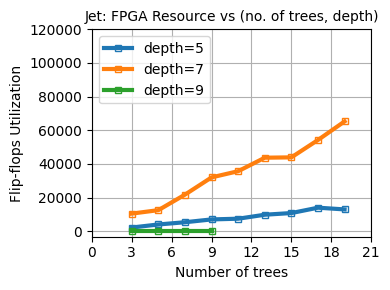

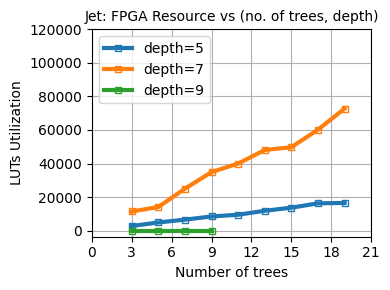

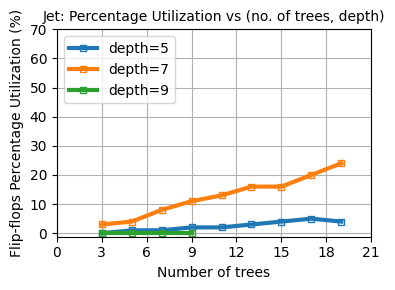

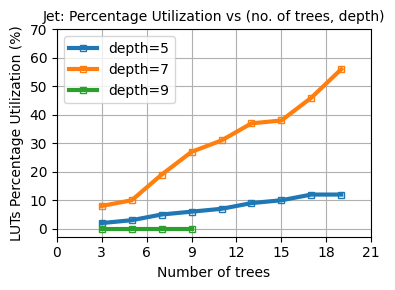

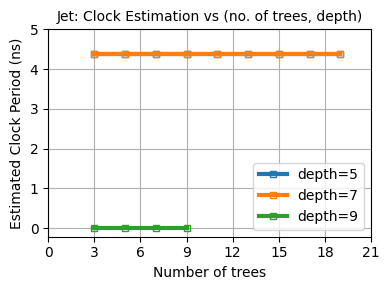

In [137]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in FFs.keys()]):
    fpga_res={}
    for n_tree in np.unique([i[0] for i in FFs.keys()]):
        try:
            fpga_res[n_tree] = FFs[(n_tree,depth)]
        except:
            pass
    plt.plot(fpga_res.keys(), fpga_res.values(), marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))   
plt.xlabel('Number of trees', size=10)
plt.ylabel('Flip-flops Utilization', size=10)
plt.title('Jet: FPGA Resource vs (no. of trees, depth)', size=10)
plt.grid()
plt.yticks([0, 20000, 40000, 60000, 80000, 100000, 120000], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, loc='upper left')
plt.tight_layout()
plt.savefig('fpgares_rf_Jet_ffs.pdf')
plt.show()

figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in LUTs.keys()]):
    fpga_res={}
    for n_tree in np.unique([i[0] for i in LUTs.keys()]):
        try:
            fpga_res[n_tree] = LUTs[(n_tree,depth)]
        except:
            pass
    plt.plot(fpga_res.keys(), fpga_res.values(), marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))   
plt.xlabel('Number of trees', size=10)
plt.ylabel('LUTs Utilization', size=10)
plt.title('Jet: FPGA Resource vs (no. of trees, depth)', size=10)
plt.grid()
plt.yticks([0, 20000, 40000, 60000, 80000, 100000, 120000], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, loc='upper left')
plt.tight_layout()
plt.savefig('fpgares_rf_Jet_luts.pdf')
plt.show()

figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in FFs_Utilization.keys()]):
    fpga_res={}
    for n_tree in np.unique([i[0] for i in FFs_Utilization.keys()]):
        try:
            fpga_res[n_tree] = FFs_Utilization[(n_tree,depth)]
        except:
            pass
    plt.plot(fpga_res.keys(), fpga_res.values(), marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))   
plt.ylabel('Flip-flops Percentage Utilization (%)', size=10)
plt.title('Jet: Percentage Utilization vs (no. of trees, depth)', size=10)
plt.xlabel('Number of trees', size=10)
plt.grid()
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, loc='upper left')
plt.tight_layout()
plt.savefig('fpgarespers_rf_Jet_ffs.pdf')
plt.show()

figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in LUTs_Utilization.keys()]):
    fpga_res={}
    for n_tree in np.unique([i[0] for i in LUTs_Utilization.keys()]):
        try:
            fpga_res[n_tree] = LUTs_Utilization[(n_tree,depth)]
        except:
            pass
    plt.plot(fpga_res.keys(), fpga_res.values(), marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))   
plt.ylabel('LUTs Percentage Utilization (%)', size=10)
plt.title('Jet: Percentage Utilization vs (no. of trees, depth)', size=10)
plt.xlabel('Number of trees', size=10)
plt.grid()
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, loc='upper left')
plt.tight_layout()
plt.savefig('fpgarespers_rf_Jet_luts.pdf')
plt.show()

figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in clock_estimate.keys()]):
    fpga_res={}
    for n_tree in np.unique([i[0] for i in clock_estimate.keys()]):
        try:
            fpga_res[n_tree] = clock_estimate[(n_tree,depth)]
        except:
            pass
    plt.plot(fpga_res.keys(), fpga_res.values(), marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))   
plt.ylabel('Estimated Clock Period (ns)', size=10)
plt.title('Jet: Clock Estimation vs (no. of trees, depth)', size=10)
plt.xlabel('Number of trees', size=10)
plt.grid()
plt.yticks([0, 1, 2, 3, 4, 5], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, loc='lower right')
plt.tight_layout()
plt.savefig('fpgarespers_rf_Jet_clock.pdf')
plt.show()